# Лабораторная №1 - Нейронная сеть прямого распространения

## Решаемая задача: распознавание рукописных символов

### Подготовка данных
В качестве датасета используется emnist-letters. Он содержит 26 сбалансированных классов - рукописные буквы латинского алфавита (строчные и прописные) в градациях серого, 28x28 пикселей.

Прочитаем данные в ndarray с помощью idx2numpy

In [2]:
import idx2numpy
import numpy as np

x_train = np.array(idx2numpy.convert_from_file('./data/emnist/emnist-letters-train-images-idx3-ubyte')).astype('float32')
y_train = np.array(idx2numpy.convert_from_file('./data/emnist/emnist-letters-train-labels-idx1-ubyte'))

x_test = np.array(idx2numpy.convert_from_file('./data/emnist/emnist-letters-test-images-idx3-ubyte')).astype('float32')
y_test = np.array(idx2numpy.convert_from_file('./data/emnist/emnist-letters-test-labels-idx1-ubyte'))

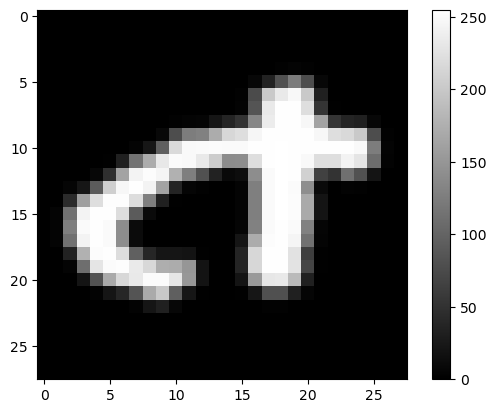

In [3]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(x_train[100], cmap='gray')
plt.colorbar()
plt.grid(False)

Изначально изображения в не очень удобном формате: цвет каждого пикселя изменяется от 0 до 255, отражены и перевёрнуты. 

Чтобы расчеты были эффективнее, разделим все значения на максимальное. Также отразим и перевернем изображения.

In [4]:
x_train /= 255
x_test /= 255

x_train = np.fliplr(x_train)
x_test = np.fliplr(x_test)

x_train = np.rot90(x_train, k=3, axes=(1, 2))
x_test = np.rot90(x_test, k=3, axes=(1, 2))

Также преобразуем каждое изображение из матрицы 28x28 в строки из 784 элементов

In [5]:
x_train = x_train.reshape(x_train.shape[0], 784)
x_test = x_test.reshape(x_test.shape[0], 784)

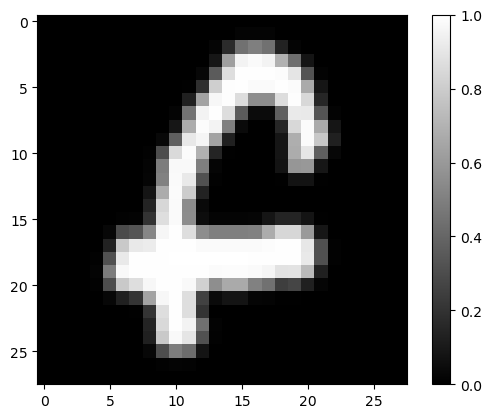

In [6]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(x_train[100].reshape(28, 28), cmap='gray')
plt.colorbar()
plt.grid(False)

В массивах правильных ответов из каждого значения вычтем 1, чтобы удобнее было индексировать

In [7]:
y_train -= 1
y_test -= 1

### Реализация сети

Класс Network - представляет сеть прямого распространения с произвольным числом слоёв, количеством нейронов в каждом, изменяемыми функциями активации (по умолчанию для скрытых слоёв ReLU, для выходного слоя softmax)

In [8]:
import time

def ReLU(x, derivative=False):
    return x * (x > 0) if not derivative else x > 0


def softmax(x):
    exp_x = np.exp(x - np.max(x))
    return exp_x / exp_x.sum(axis=1, keepdims=True)

class Network:

    def __init__(self, sizes, activation_func=ReLU, output_func=softmax):
        self.sizes = sizes
        self.activation_func = activation_func
        self.output_func = output_func
        # self._norm_init()
        # self._xavier_init()
        self._he_init()

    def _norm_init(self):
        
        self.weights = []
        self.biases = []
        self.activations = []
        self.deltaW = []
        self.deltaB = []
        
        for i in range(1, len(self.sizes)):
            self.weights.append(0 + 0.5 * np.random.randn(self.sizes[i-1], self.sizes[i]))
            self.biases.append(np.zeros((1, self.sizes[i])))

    def _xavier_init(self):
        
        self.weights = []
        self.biases = []
        self.activations = []
        self.deltaW = []
        self.deltaB = []
        
        for i in range(1, len(self.sizes)):
            left, right = self.sizes[i-1], self.sizes[i]
            limit = np.sqrt(6 / (left + right))
            self.weights.append(np.random.uniform(-limit, limit, size=(left, right)))
            self.biases.append(np.zeros((1, self.sizes[i])))
            
    def _he_init(self):
        self.weights = []
        self.biases = []
        self.activations = []
        self.deltaW = []
        self.deltaB = []
        
        for i in range(1, len(self.sizes)):
            left, right = self.sizes[i-1], self.sizes[i]
            limit = np.sqrt(2 / left)
            self.weights.append(np.random.uniform(-limit, limit, size=(left, right)))
            self.biases.append(np.zeros((1, self.sizes[i])))
       
    def _forward(self, x):
        self.activations = [np.array(x).reshape(1, len(x))]
        
        for i in range(len(self.sizes)-2):
            self.activations.append(self.activation_func(np.dot(self.activations[-1], self.weights[i]) + self.biases[i]))

        self.activations.append(self.output_func(np.dot(self.activations[-1], self.weights[-1]) + self.biases[-1]))
        
        return self.activations[-1]

    def _backprop(self, y_valid):
        self.deltaW = []
        self.deltaB = []
        error = self.activations[len(self.sizes)-1] - y_valid
        
        for i in range(len(self.sizes)-2, -1, -1):
            self.deltaW.insert(0, np.dot(self.activations[i].T, error))
            self.deltaB.insert(0, np.sum(error, axis=0, keepdims=True))
            error = np.dot(error, self.weights[i].T) * ReLU(self.activations[i], derivative=True)

    def _update_params(self, learning_rate):
        
        for i in range(len(self.weights)):
            self.weights[i] -= learning_rate * self.deltaW[i]
            self.biases[i] -= learning_rate * self.deltaB[i]
        
    def _onehot(self, y):
        one_hot = np.zeros((1, self.sizes[-1]))
        one_hot[0, y] = 1
        return one_hot
        
    def fit(self, x_train, y_train, x_test, y_test, epochs, learning_rate, print_all=True):
        time_data = []
        loss_data = []
        acc_data = []
        start = time.time()
        for epoch in range(epochs):
            total_loss = 0
            epoch_start = time.time()
            for x, y in zip(x_train, y_train):
                y_onehot = self._onehot(y)
                self._forward(x)
                self._backprop(y_onehot)
                self._update_params(learning_rate)
                self._forward(x)
                output = self.activations[-1]
                loss = -np.sum(y_onehot * np.log(output + 1e-8))
                total_loss += loss
            avg_loss = total_loss / len(x_train)
            loss_data.append(avg_loss)
            accuracy = self.test(x_test, y_test)
            acc_data.append(accuracy)
            if print_all or (epoch + 1) % 5 == 0:
                print(f"====================================\n"
                      f"Epoch {epoch + 1}/{epochs}\nLoss: {avg_loss:.4f}")
                print(f'Accuracy: {accuracy:.2f}%')
            time_data.append(time.time() - epoch_start)
        print(f'====================================\n'
              f'Total time: {time.time() - start:.2f}')
        
        return time_data, loss_data, acc_data
    
    def test(self, x_test, y_test):
        correct = 0
        for x, y in zip(x_test, y_test):
            prediction = self.predict(x)
            if prediction == y:
                correct += 1

        return correct / len(y_test) * 100

    def predict(self, x):
        self._forward(x)
        return np.argmax(self.activations[-1])

Начнем с одного скрытого слоя с 32 нейронами

In [11]:
input_ = x_train.shape[1]  # размерность входных данных
output = len(np.unique(y_train))  # количество классов
experiment_data = {}

model1 = Network([input_, 32, output])
experiment_data[32] = (model1, model1.fit(x_train, y_train, x_test[:len(x_test)//2], y_test[:len(y_test)//2], epochs=10, learning_rate=0.01))

Epoch 1/10
Loss: 0.3390
Accuracy: 74.89%
Epoch 2/10
Loss: 0.2291
Accuracy: 74.70%
Epoch 3/10
Loss: 0.2119
Accuracy: 75.65%
Epoch 4/10
Loss: 0.2077
Accuracy: 76.15%
Epoch 5/10
Loss: 0.2055
Accuracy: 76.10%
Epoch 6/10
Loss: 0.2011
Accuracy: 76.94%
Epoch 7/10
Loss: 0.1974
Accuracy: 76.13%
Epoch 8/10
Loss: 0.1947
Accuracy: 76.07%
Epoch 9/10
Loss: 0.1913
Accuracy: 75.49%
Epoch 10/10
Loss: 0.1892
Accuracy: 75.53%
Total time: 85.39


Попробуем увеличивать число нейронов

In [15]:
model2 = Network([input_, 64, output])
experiment_data[64] = (model2, model2.fit(x_train, y_train, x_test[:len(x_test)//2], y_test[:len(y_test)//2], epochs=10, learning_rate=0.01))

Epoch 1/10
Loss: 0.2418
Accuracy: 78.27%
Epoch 2/10
Loss: 0.1380
Accuracy: 80.28%
Epoch 3/10
Loss: 0.1254
Accuracy: 81.30%
Epoch 4/10
Loss: 0.1166
Accuracy: 81.72%
Epoch 5/10
Loss: 0.1110
Accuracy: 81.27%
Epoch 6/10
Loss: 0.1074
Accuracy: 81.60%
Epoch 7/10
Loss: 0.1034
Accuracy: 81.65%
Epoch 8/10
Loss: 0.1017
Accuracy: 82.29%
Epoch 9/10
Loss: 0.0996
Accuracy: 81.82%
Epoch 10/10
Loss: 0.0975
Accuracy: 82.02%
Total time: 109.32


In [16]:
model3 = Network([input_, 128, output])
experiment_data[128] = (model3, model3.fit(x_train, y_train, x_test[:len(x_test)//2], y_test[:len(y_test)//2], epochs=10, learning_rate=0.01, print_all=False))

Epoch 5/10
Loss: 0.0647
Accuracy: 84.13%
Epoch 10/10
Loss: 0.0502
Accuracy: 84.96%
Total time: 165.34


In [17]:
model4 = Network([input_, 256, output])
experiment_data[256] = (model4, model4.fit(x_train, y_train, x_test[:len(x_test)//2], y_test[:len(y_test)//2], epochs=10, learning_rate=0.01, print_all=False))

Epoch 5/10
Loss: 0.0463
Accuracy: 85.40%
Epoch 10/10
Loss: 0.0324
Accuracy: 85.50%
Total time: 770.74


In [18]:
model5 = Network([input_, 64, 32, output])
experiment_data[64*32] = (model5, model5.fit(x_train, y_train, x_test[:len(x_test)//2], y_test[:len(y_test)//2], epochs=10, learning_rate=0.01, print_all=False))

Epoch 5/10
Loss: 0.1318
Accuracy: 78.83%
Epoch 10/10
Loss: 0.1254
Accuracy: 81.22%
Total time: 130.15


In [19]:
model6 = Network([input_, 128, 64, output])
experiment_data[128*64] = (model6, model6.fit(x_train, y_train, x_test[:len(x_test)//2], y_test[:len(y_test)//2], epochs=10, learning_rate=0.01, print_all=False))

Epoch 5/10
Loss: 0.0768
Accuracy: 82.88%
Epoch 10/10
Loss: 0.0720
Accuracy: 83.98%
Total time: 190.62


In [20]:
model7 = Network([input_, 256, 128, output])
experiment_data[256*128] = (model7, model7.fit(x_train, y_train, x_test[:len(x_test)//2], y_test[:len(y_test)//2], epochs=10, learning_rate=0.01, print_all=False))

Epoch 5/10
Loss: 0.0458
Accuracy: 87.14%
Epoch 10/10
Loss: 0.0379
Accuracy: 86.21%
Total time: 911.53


In [21]:
model8 = Network([input_, 512, 256, output])
experiment_data[512*256] = (model8, model8.fit(x_train, y_train, x_test[:len(x_test)//2], y_test[:len(y_test)//2], epochs=10, learning_rate=0.01, print_all=False))

Epoch 5/10
Loss: 0.0335
Accuracy: 86.65%
Epoch 10/10
Loss: 0.0264
Accuracy: 86.53%
Total time: 2529.92


In [37]:
x_valid = x_test[len(x_test)//2:]
y_valid = y_test[len(y_test)//2:]
valid_accuracy = model.test(x_valid, y_valid)
print(f'Validation accuracy: {valid_accuracy:.2f}%')

Validation accuracy: 89.21%


Среднее время выполнения одной итерации: 86.88


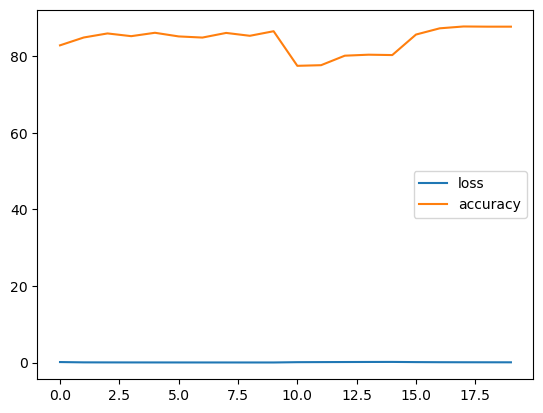

In [65]:
# print(f'Среднее время выполнения одной итерации: {np.mean(time_data):.2f}')
# x_i = [i for i in range(20)]
# plt.plot(x_i, loss_data, label='loss')
# plt.plot(x_i, acc_data / 100, label='accuracy')
# plt.legend()
# plt.show()

In [67]:
def visualize(images, predictions, real, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(10, 2))
    for i in range(num_images):
        axes[i].imshow(images[i].reshape(28, 28), cmap='gray')
        axes[i].set_title(f'Prediction: {chr(idx[str(predictions[i])])}\nActual: {chr(idx[str(real[i])])}')
        axes[i].axis('off')
    plt.show()

In [1]:
with open('data/emnist/emnist-letters-mapping.txt', 'r') as mapping_file:
    idx = {}
    for line in mapping_file.readlines():
        items = line.split()
        idx[str(int(items[0])-1)] = int(items[1])

predictions = []
count = 5
x = []
y = []
for i in range(count):
    i_x = np.random.randint(0, x_valid.shape[0])
    x.append(x_valid[i_x])
    y.append(y_valid[i_x])
    predictions.append(model.predict(x_valid[i_x]))
visualize(x, predictions, y, count)

NameError: name 'np' is not defined